In [2]:
#Run this notebook in the root directory of the project
%cd ../../../

/data/main/2024/GridCellsCond


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal,stats
import analysis_utils as a_utils
import sim_utils as s_utils
from scipy import signal
from scipy import ndimage
from scipy import stats
import seaborn as sns

In [9]:
sim_id='VALD-ACVT-2D-S-s-2a'
params = s_utils.load_sim_params(sim_id)
stell_spks_l,intrnrn_spks_l = s_utils.load_spikes(sim_id)

In [10]:
n_per_sheet=params["N_per_sheet"]
sheet_to_plot=0
idx = np.full((4,2),n_per_sheet)*np.array([[0,1],[1,2],[2,3],[3,4]])
stell_spks_reshaped = a_utils.spks_to_rate_reshaped(stell_spks_l[idx[sheet_to_plot][0]:idx[sheet_to_plot][1]],params,win_size=100)

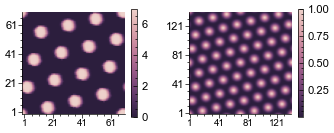

In [11]:
plt.style.use("analysis/config/paper.mplstyle")
plt.rcParams.update({'xtick.labelsize': 7})
t_plot = 5000
auto_corr,grid_score,grid_scale,grid_size = a_utils.grid_props_2D(stell_spks_reshaped,t=t_plot)
stell_spks_reshaped_flipped= np.flip(stell_spks_reshaped,axis=0) # let matplotlib handle origin
fig,axs=plt.subplots(1,2,figsize=(3.503+0.3,1.4))
im0=axs[0].imshow(stell_spks_reshaped_flipped[:,:,t_plot],cmap=sns.cubehelix_palette(as_cmap=True,reverse=True),origin="lower")
cbar = axs[0].figure.colorbar(im0, ax=axs[0])
# cbar.ax.set_ylabel("F", rotation=-90, va="bottom")

axs[0].set(xticks=np.arange(1,params["N_per_axis"],20),xticklabels=np.arange(1,params["N_per_axis"],20),yticks=np.arange(1,params["N_per_axis"],20),yticklabels=np.arange(1,params["N_per_axis"],20))
axs[0].tick_params(which="both",direction="out",pad=0.5)
axs[0].grid(False)
auto_corr_flipped= np.flip(auto_corr,axis=0) # let matplotlib handle origin
im1=axs[1].imshow(auto_corr_flipped,cmap=sns.cubehelix_palette(as_cmap=True,reverse=True),origin="lower")
cbar = axs[1].figure.colorbar(im1, ax=axs[1])
axs[1].set(xticks=np.arange(1,params["N_per_axis"]*2,40),xticklabels=np.arange(1,params["N_per_axis"]*2,40),yticks=np.arange(1,params["N_per_axis"]*2,40),yticklabels=np.arange(1,params["N_per_axis"]*2,40))
axs[1].tick_params(which="both",direction="out",pad=0.5)
axs[1].grid(False)
plt.subplots_adjust(wspace=0.3)
plt.savefig('analysis/figures/Fig1/Fig1_C.svg',dpi=300)
plt.show()

In [12]:
print(f'Gridness Score: {grid_score} | Grid Scale: {grid_scale} | Grid Field Size: {grid_size}')

Gridness Score: 1.06 | Grid Scale: 19.65 | Grid Field Size: 11.5


In [14]:
a_utils.generate_2d_video(sim_id)

Reshaping array
Generating video for VALD-ACVT-2D-S-s-2a, sheet: 0
Video saved in data/VALD-ACVT-2D-S-s-2a/VALD-ACVT-2D-S-s-2a_0.mp4  t_total (s): 37.29
